In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from scipy.interpolate import interp1d
# from plot_funcs import *
from matplotlib import patches

In [28]:
def modecount_rebin(kk, pk, modes, minmodes=20, ndesired=200): #from MP-Gadget
    """Rebins a power spectrum so that there are sufficient modes in each bin"""
    assert np.all(kk) > 0
    logkk=np.log10(kk)
    mdlogk = (np.max(logkk) - np.min(logkk))/ndesired
    istart=iend=1
    count=0
    k_list=[kk[0]]
    pk_list=[pk[0]]
    targetlogk=mdlogk+logkk[istart]
    while iend < np.size(logkk)-1:
        count+=modes[iend]
        iend+=1
        if count >= minmodes and logkk[iend-1] >= targetlogk:
            pk1 = np.sum(modes[istart:iend]*pk[istart:iend])/count
            kk1 = np.sum(modes[istart:iend]*kk[istart:iend])/count
            k_list.append(kk1)
            pk_list.append(pk1)
            istart=iend
            targetlogk=mdlogk+logkk[istart]
            count=0
    k_list = np.array(k_list)
    pk_list = np.array(pk_list)
    return (k_list, pk_list)

def load_rebin(spec_file):
    k_raw, Pk_raw, modes = np.loadtxt(spec_file, usecols=(0,1,2), unpack=True)
    k, Pk = modecount_rebin(k_raw, Pk_raw, modes)
    return k, Pk

In [29]:
# relative difference
def rel_dif(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    common_log10_x = np.linspace(common_log10_x_min, common_log10_x_max, 100)

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    delta_y = (interp_y2 - interp_y1) / interp_y1
    return common_x, delta_y

In [30]:
def rMAE_av_cosmo(pred_parent, sim_parent, z, n_HF, exclude=None):
    Ps_pred, nz_ind = load_pred(pred_parent, z, n_HF)
    k_sim, Ps_sim = load_sim(sim_parent, z, nz_ind)
    k, rAEs = rel_MAEs(k_sim, Ps_sim, k_sim, Ps_pred)
    if exclude is not None:  # exclude some cosmologies
        rAEs = np.delete(rAEs, exclude, axis=0)
    rMAE_av = np.mean(rAEs, axis=0)

    rAE_av_k = np.mean(rAEs, axis=1)
    print('z=', z, rAE_av_k)
    # print('z=', z, rAEs)
    # min and max
    rMAE_min, rMAE_max = np.min(rAEs, axis=0), np.max(rAEs, axis=0)
    return k, rMAE_av, rMAE_min, rMAE_max, rAEs

def load_pred(pred_parent, z, n_HF):
    Ps_pred = []
    nz_ind = []  # for matching sim spectra
    for i in range(n_HF):
        file_path = os.path.join(pred_parent, "matter_pow_z%s_l%d.txt" % (z, i))
        if os.path.exists(file_path):
            # print(f"The file {file_path} exists.")
            data = np.loadtxt(file_path,)
            data = data.transpose()
            P_pred = data[-1]
            Ps_pred.append(P_pred)
            nz_ind.append(i)
        else:
            print(f"The file {file_path} does not exist.")
            continue
    Ps_pred = np.array(Ps_pred)
    return Ps_pred, nz_ind

def load_sim(sim_base, z, nz_ind):
    file_path = os.path.join(sim_base + "_z%s" % z, 'train_output_fidelity_1.txt')
    k_path = os.path.join(sim_base + "_z%s" % z, 'kf.txt')
    lg_Ps = np.loadtxt(file_path)
    lg_Ps = lg_Ps[nz_ind]
    Ps_sim = 10**lg_Ps
    lg_k = np.loadtxt(k_path, usecols=(0))
    k_sim = 10**lg_k
    return k_sim, Ps_sim


def rel_MAEs(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    common_log10_x = np.linspace(common_log10_x_min, common_log10_x_max, 100)

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    rMAE_y = np.abs((interp_y2 / interp_y1) - 1)
    return common_x, rMAE_y

z= 0 [0.01261507 0.01923244 0.03461167 0.01642174 0.01968124 0.13402562
 0.01458555 0.00761554 0.05479084 0.01702639 0.05800556 0.03762467
 0.04105527 0.02887027 0.05312344 0.01365602 0.01725479 0.01368666
 0.05283355 0.03020511 0.01596937]
z= 0 [0.03117071 0.01623292 0.05474284 0.01709771 0.02569561 0.04231549
 0.01270584 0.0426023  0.04290591 0.02799306 0.03229481 0.02549202
 0.00715614 0.03472265 0.02136551 0.01412573 0.04119876 0.04557253
 0.08900568 0.03335544 0.030347  ]
z= 0.2 [0.02161973 0.02228105 0.02868982 0.0294862  0.02912084 0.14279739
 0.00745407 0.02146875 0.05814923 0.0194603  0.03352342 0.02673902
 0.02790702 0.02842411 0.19253444 0.038063   0.02983974 0.00896735
 0.04778282 0.02382035 0.01233887]
z= 0.2 [0.03567728 0.01500852 0.0593883  0.01763213 0.030844   0.03331949
 0.01892796 0.04006641 0.03799087 0.03341285 0.03534672 0.03486732
 0.00923432 0.04116836 0.02380927 0.00857947 0.05398376 0.01997358
 0.10553312 0.03961185 0.02235564]
z= 0.5 [0.010998   0.01295325 0.

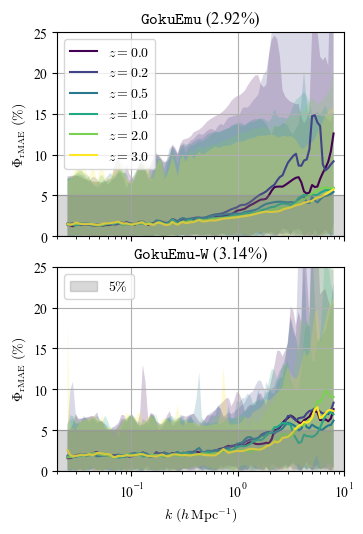

In [ ]:
# relative
# sim_parent = "/work2/01317/yyang440/frontera/cosmo_11p_sims/data_for_emu" # frontera
sim_base = "../data/narrow/matter_power_564_Box1000_Part750_15_Box1000_Part3000" 
# pred_combined_parent = './loo_combined_upper/'

# sim_W_base = "../data/matter_power_564_Box1000_Part750_21_Box1000_Part3000" 
# pred_W_parent = './loo_upper/'

fig, ax = plt.subplots(1, 1, figsize=(3.7, 5.7), sharex=True)
fig.subplots_adjust(hspace=0.15)
plt.rcParams['font.family'] = 'Times New Roman'

# Set math font style
plt.rcParams['mathtext.fontset'] = 'cm'

zs = np.array([0,0.2, 0.5, 1, 2, 3, 4, 9, 49, 99])
zs_str = ['0', '0.2', '0.5', '1', '2', '3', '4', '9', '49', '99']
a = 1/(1+zs)

cmap = "viridis"
cmap = plt.get_cmap(cmap)
color_list = [x for x in cmap(np.arange(len(zs[:6]))/(len(zs[:6])-1))]

# ax.plot([], [], color='black', label='HF')
# # ax.plot([], [], color='black', linestyle=':', label='L1')
# ax.plot([], [], color='black', linestyle='--', label='Linear')
rMAE_zs = []
rMAE_zs_W = []

for i, scale in enumerate(a):
    if i==2:  # redshifts
        break
    c = color_list[i]
    # k_L1, Pk_L1 = load_rebin(os.path.join(sim_L1, "output/powerspectrum-%.4f.txt" % scale))
    # k_L2, Pk_L2 = load_rebin(os.path.join(sim_L2, "output/powerspectrum-%.4f.txt" % scale))
    

    k, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(pred_combined_parent, sim_combined_base, zs_str[i], 15)
    rMAE_zs.append(rMAE.mean())

    ax.plot(k, rMAE/1e-2, color=c, label=r"$z=%.1f$" % zs[i])
    ax.fill_between(k, rMAE_min/1e-2, rMAE_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')

    k, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(pred_W_parent, sim_W_base, zs_str[i], 21)
    rMAE_zs_W.append(rMAE.mean())

    ax.plot(k, rMAE/1e-2, color=c)
    ax.fill_between(k, rMAE_min/1e-2, rMAE_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')
    
rMAE_zs = np.array(rMAE_zs)
rMAE_zs_mean = rMAE_zs.mean()
print('average over k and z (combined):', rMAE_zs_mean)

rMAE_zs_W = np.array(rMAE_zs_W)
rMAE_zs_mean_W = rMAE_zs_W.mean()
print('average over k and z (W-only):', rMAE_zs_mean_W)
    

    # if labels is not None:

# title
ax.set_title(r'$\tt{GokuEmu}$' + f' ({100*rMAE_zs_mean:.2f}%)')
ax.set_title(r'$\tt{GokuEmu}$'+'-' + r'$\tt{W}$' + f' ({100*rMAE_zs_mean_W:.2f}%)')


ax.set_ylabel(r'$\Phi_{\mathrm{rMAE}}\ (\%)$')
ax.set_ylabel(r'$\Phi_{\mathrm{rMAE}}\ (\%)$')
# plt.xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# plt.ylabel(r'$P(k)\ (h^{-3}\mathrm{Mpc}^3)$')
# ax.plot([], [], color='black', label='HF')
# ax.plot([], [], color='black', label='HF w.r.t. Linear')
# ax.plot([], [], color='black', linestyle='--', label='L2 w.r.t. HF')
ax.set_ylim(0., 25)
ax.set_ylim(0., 25)
ax.set_xscale('log')
ax.set_xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# ax.set_ylabel(r'$(P_\mathrm{HF}-P_\mathrm{Li})/P_\mathrm{Li}$')

xlim1 = .02
xlim2 = 10
ax.set_xlim(xlim1, xlim2)

square = patches.Rectangle((xlim1, -0.0), xlim2-xlim1, 5, color='gray', alpha=.3, zorder=2)  # alpha ranges from 0 (transparent) to 1 (opaque)
# Add the square to the axes
ax.add_patch(square)
# ax.add_patch(square1)
ax.legend(loc='upper left')

square1 = patches.Rectangle((xlim1, -0.0), xlim2-xlim1, 5, color='gray', alpha=.3, zorder=2, label=r'$5\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)
# Add the square to the axes
ax.add_patch(square1)
# ax.add_patch(square1)
ax.legend(loc='upper left')

# grid true
for ax in axes:
    ax.grid(True)


# plt.show()
plt.savefig('loo_against_W.pdf', bbox_inches='tight')